# Network SIDARTHE model

SIDARTHE is an 8-state model described by the following system of differential equations:

$$
    \frac{dS}{dt} = - (\alpha I + \beta D + \gamma A + \delta R) S
$$

$$
    \frac{dI}{dt} = (\alpha I + \beta D + \gamma A + \delta R) S - (\epsilon + \gamma + \lambda) I
$$

$$
    \frac{dD}{dt} = \epsilon I - (\eta + \rho) D
$$

$$
    \frac{dA}{dt} = \zeta I - (\theta + \mu + \kappa) A
$$

$$
    \frac{dR}{dt} = \eta D + \theta A - (\nu + \xi) R
$$

$$
    \frac{dT}{dt} = \mu A + \nu R - (\sigma + \tau) T
$$

$$
    \frac{dH}{dt} = \lambda I + \rho D + \kappa A + \xi R + \sigma T
$$

$$
    \frac{dE}{dt} = \tau T
$$


| Symbol      | Parameter                                      | Value             |
|-------------|------------------------------------------------|-------------------|
| $\alpha$    | Transmission rate $I \to S$                    | $0.570$           |
| $\beta$     | Transmission rate $D \to S$                    | $0.01$            |
| $\gamma$    | Transmission rate $A \to S$                    | $0.456$           |
| $\delta$    | Transmission rate $R \to S$                    | $0.01$            |
| $\epsilon$  | Asymptomatic rate of detection ($A \to R$)     | $0.17$            |
| $\theta$    | Symptomatic rate of detection ($I \to D$)      | $0.371$           |
| $\zeta$     | Probability of developing symptoms ($I \to A$) | $0.125$           |
| $\eta$      | Probability of developing symptoms ($D \to R$) | $0.125$           |
| $\mu$       | Probability of severe symptoms ($A \to T$)     | $0.017$           |
| $\nu$       | Probability of severe symptoms ($D \to T$)     | $0.027$           |
| $\lambda$   | Recovery rate $I \to H$                        | $0.034$           |
| $\kappa$    | Recovery rate $A \to H$                        | $0.017$           |
| $\xi$       | Recovery rate $R \to H$                        | $0.017$           |
| $\rho$      | Recovery rate $D \to H$                        | $0.034$           |
| $\sigma$    | Recovery rate $T \to H$                        | $0.017$           |
| $\tau$      | Mortality ($T \to E$)                          | $0.01$            |

| Compartment | Description                                    | $C(0)/N$          |
|-------------|------------------------------------------------|-------------------|
| $I$         | Infected (asymptomatic, undetected)            | $3 \times 10^{-5}$|
| $D$         | Diagnosed (asymptomatic, detected)             | $3 \times 10^{-5}$|
| $A$         | Ailing (symptomatic, undetected)               | $1 \times 10^{-6}$|
| $R$         | Recognised (symptomatic, detected)             | $2 \times 10^{-7}$|

In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from matplotlib import pyplot as plt
from matplotlib import colors as clrs
import networkx as nx
import json
from scipy import stats
import enum


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    DIAGNOSED = 2
    AILING = 3
    RECOGNISED = 4
    THREATENED = 5
    HEALED = 6
    EXTINCT = 7

In [3]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # Naive start
        self.state = State.SUSCEPTIBLE

    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if self.state in [State.INFECTED, State.DIAGNOSED, State.AILING, State.RECOGNISED]:
                if self.state == State.INFECTED:
                    p_i = self.model.alpha
                if self.state == State.DIAGNOSED:
                    p_i = self.model.beta
                if self.state == State.AILING:
                    p_i = self.model.gamma
                if self.state == State.RECOGNISED:
                    p_i = self.model.delta

                if np.random.rand() < p_i/len(susceptible_neighbourhood):
                    neighbour.state = State.INFECTED

    def status_update(self):
        if self.state == State.INFECTED:
            if np.random.rand() < self.model.zeta:
                self.state = State.AILING
            elif np.random.rand() < self.model.epsilon:
                self.state = State.DIAGNOSED
            elif np.random.rand() < self.model.blamda:
                self.state = State.HEALED

        if self.state == State.DIAGNOSED:
            if np.random.rand() < self.model.eta:
                self.state = State.RECOGNISED
            elif np.random.rand() < self.model.rho:
                self.state = State.HEALED

        if self.state == State.AILING:
            if np.random.rand() < self.model.theta:
                self.state = State.RECOGNISED
            elif np.random.rand() < self.model.mu:
                self.state = State.THREATENED
            elif np.random.rand() < self.model.kappa:
                self.state = State.HEALED

        if self.state == State.RECOGNISED:
            if np.random.rand() < self.model.nu:
                self.state = State.THREATENED
            elif np.random.rand() < self.model.xi:
                self.state = State.HEALED
            
        if self.state == State.THREATENED:
            if np.random.rand() < self.model.sigma:
                self.state = State.HEALED
            elif np.random.rand() < self.model.tau:
                self.state = State.EXTINCT

    def step(self):
        self.status_update()
        self.contact_event()
    

    def toJSON(self):        
        key = self.unique_id
        return json.dumps(key, default=lambda o: o.__dict__, sort_keys=True, indent=4)

In [4]:
class NetworkSIDARTHE(Model):

    def __init__(self, 
                 nodes=1e3, 
                 mean_degree=10,
                 alpha=0.570, 
                 beta=0.01, 
                 gamma=0.456, 
                 delta=0.01, 
                 epsilon=0.17, 
                 theta=0.371, 
                 zeta=0.125, 
                 eta=0.125, 
                 mu=0.017, 
                 nu=0.027, 
                 blamda=0.034, 
                 kappa=0.017, 
                 xi=0.017, 
                 rho=0.034, 
                 sigma=0.017, 
                 tau=0.01,
                 I0=1e-4, 
                 D0=1e-4, 
                 A0=1e-5, 
                 R0=2e-5):

        self.alpha, self.beta, self.gamma, self.delta = alpha, beta, gamma, delta
        self.epsilon, self.theta = epsilon, theta
        self.zeta, self.eta, self.mu, self.nu = zeta, eta, mu, nu
        self.blamda, self.kappa, self.xi, self.rho, self.sigma = blamda, kappa, xi, rho, sigma
        self.tau = tau
        self.I0, self.D0, self.A0, self.R0 = I0, D0, A0, R0

        self.graph = nx.erdos_renyi_graph(n=nodes, p=mean_degree/nodes)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True

        for idx, node in enumerate(self.graph.nodes()):
            agent = Person(uid=idx + 1, model=self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if np.random.rand() < I0:
                agent.state = State.INFECTED
            elif np.random.rand() < D0:
                agent.state = State.DIAGNOSED
            elif np.random.rand() < A0:
                agent.state = State.AILING
            elif np.random.rand() < R0:
                agent.state = State.RECOGNISED
            else:
                agent.state = State.SUSCEPTIBLE

        self.datacollector = DataCollector(agent_reporters={"State": "state"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def to_df(self):
        output_df = pd.pivot_table(model.datacollector.get_agent_vars_dataframe().reset_index(), 
                       index="Step", 
                       columns="State", 
                       aggfunc=np.size, 
                       fill_value=0)

        output_df.columns = list(map(lambda x: State._member_names_[x[1]].title(), output_df.columns))
        
        return output_df

In [5]:
pop=50_000
steps=120

model = NetworkSIDARTHE(pop)

for i in range(steps):
    model.step()

model_results = model.to_df()

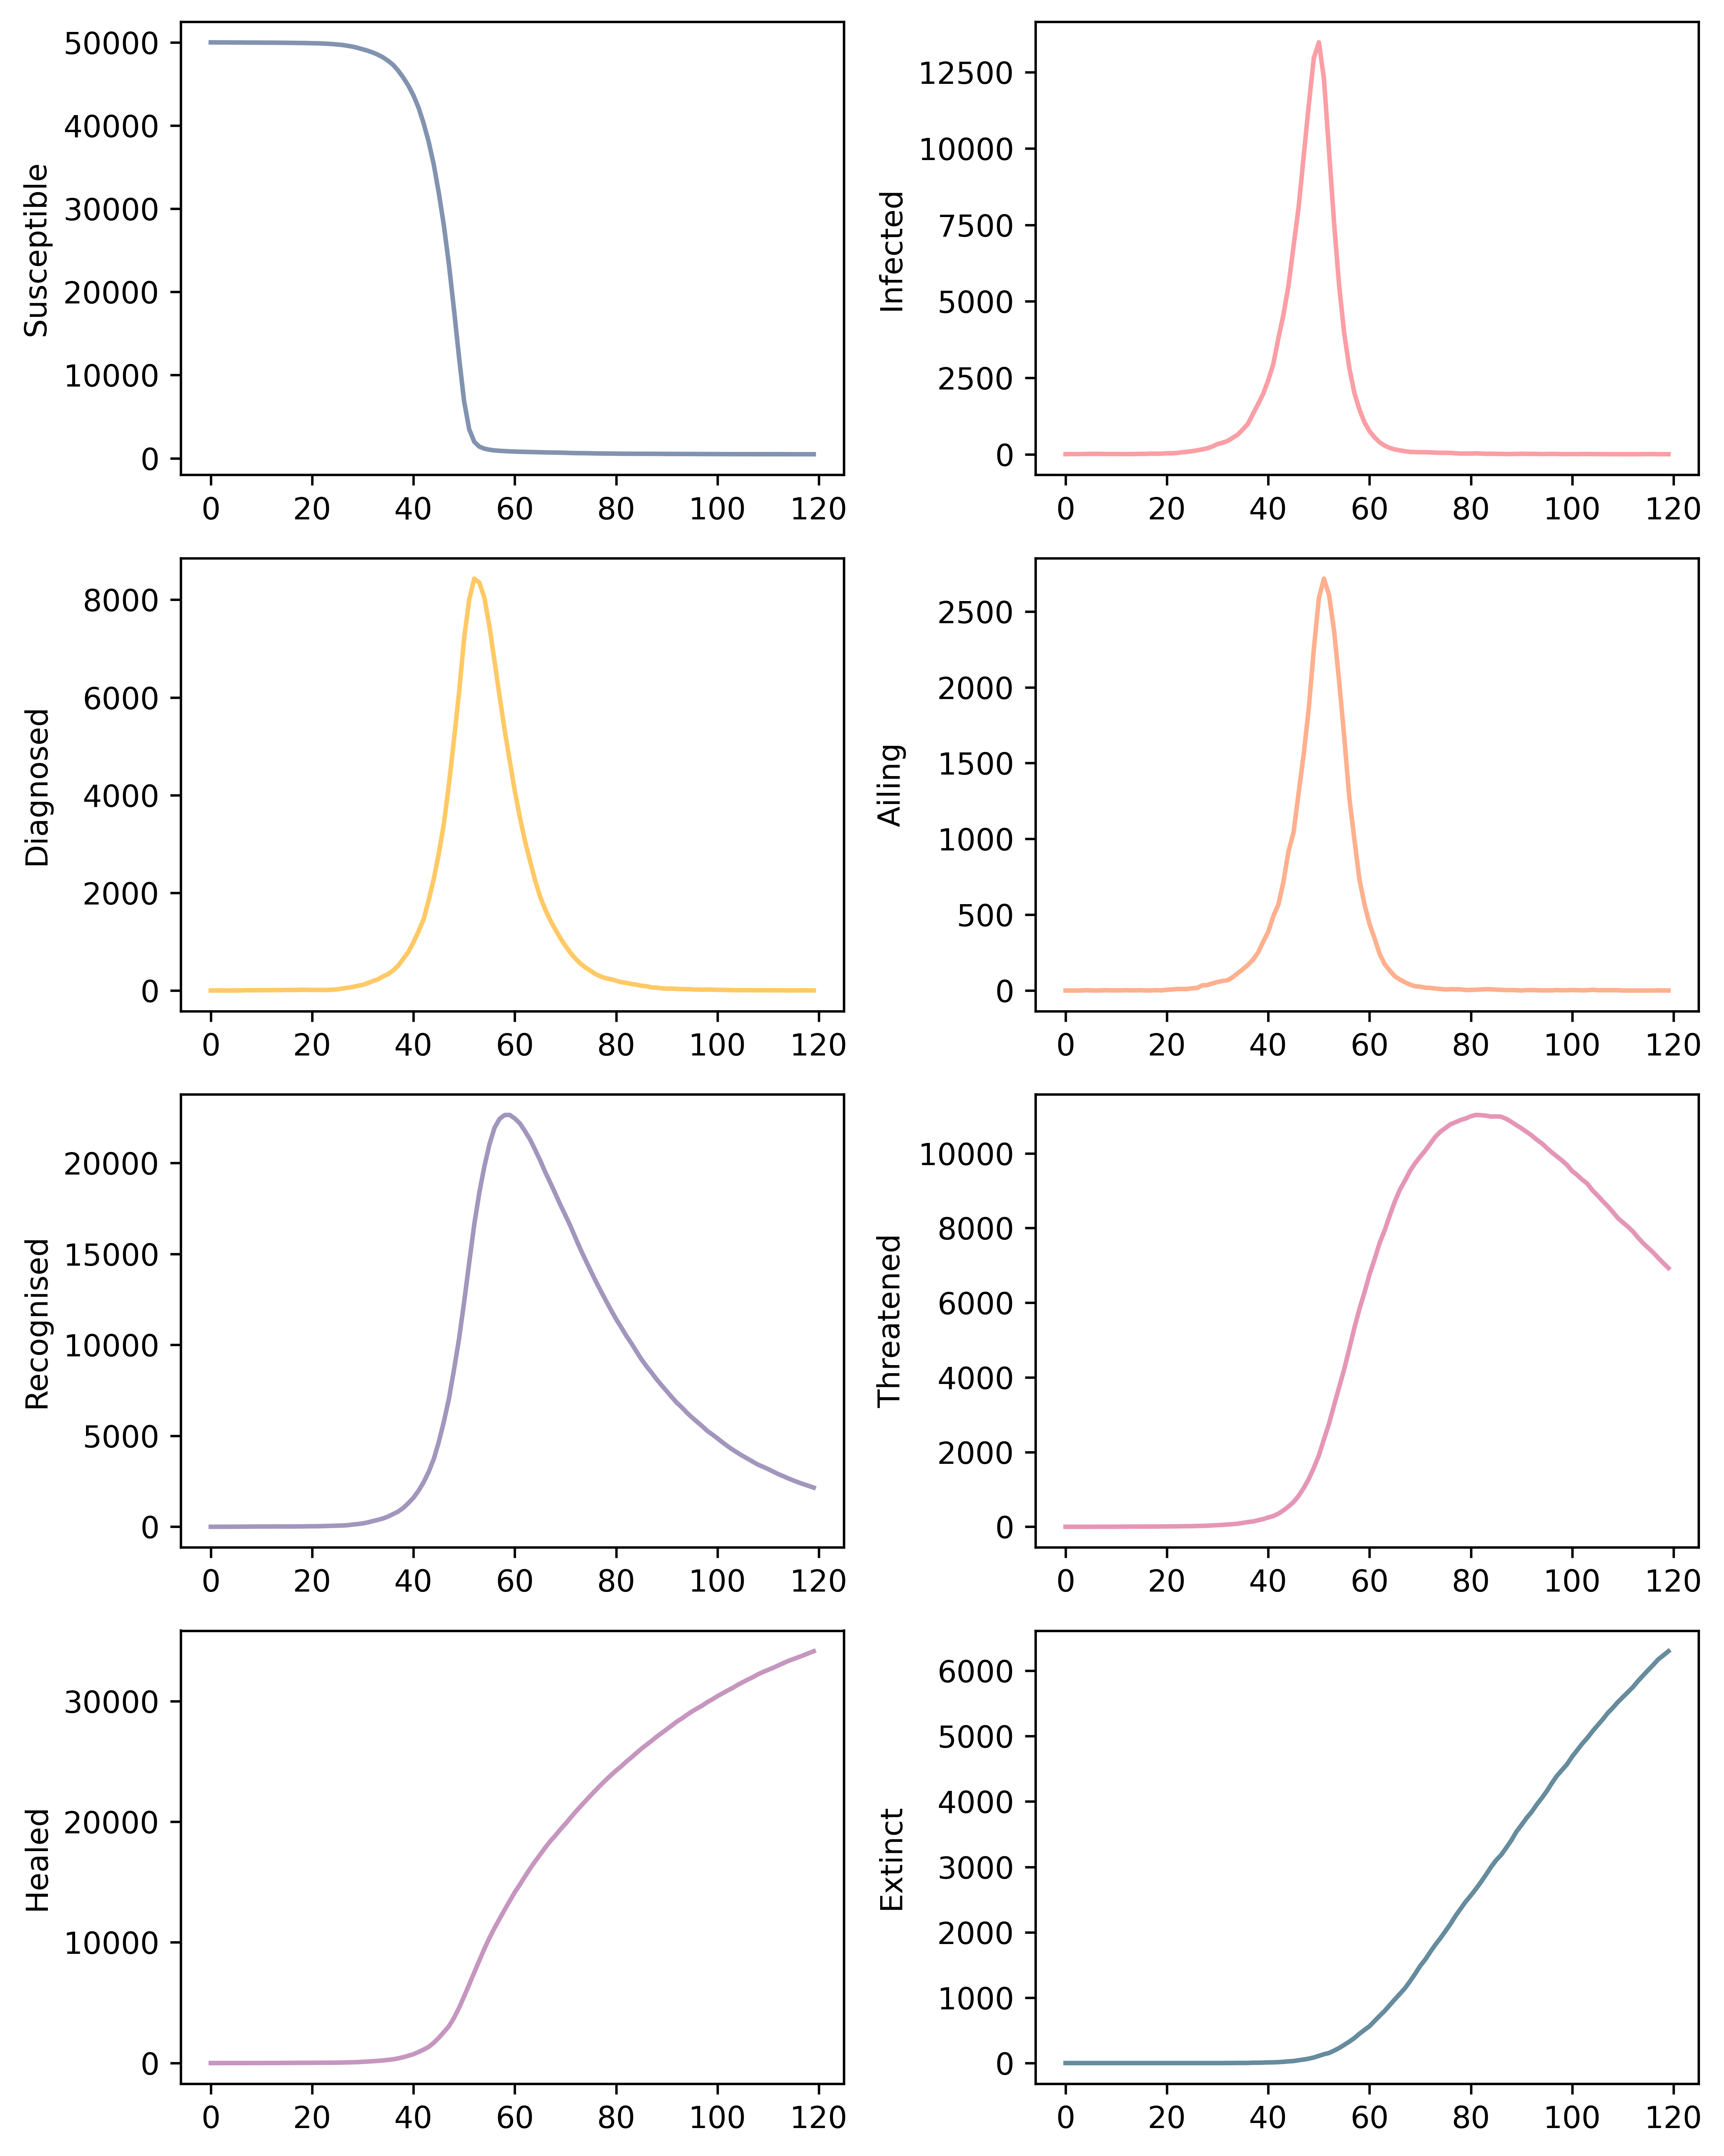

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=2, facecolor="w", figsize=(8, 10), dpi=600)

# S
ax = axs[0, 0]
ax.plot(model_results.index, model_results.Susceptible, color=COLORS["S"], alpha=0.6)
ax.set_ylabel("Susceptible")

# I
ax = axs[0, 1]
ax.plot(model_results.index, model_results.Infected, color=COLORS["I"], alpha=0.6)
ax.set_ylabel("Infected")

# D
ax = axs[1, 0]
ax.plot(model_results.index, model_results.Diagnosed, color=COLORS["E"], alpha=0.6)
ax.set_ylabel("Diagnosed")

# A
ax = axs[1, 1]
ax.plot(model_results.index, model_results.Ailing, color=COLORS["C"], alpha=0.6)
ax.set_ylabel("Ailing")

# R
ax = axs[2, 0]
ax.plot(model_results.index, model_results.Recognised, color=COLORS["X"], alpha=0.6)
ax.set_ylabel("Recognised")

# T
ax = axs[2, 1]
ax.plot(model_results.index, model_results.Threatened, color=COLORS["Y"], alpha=0.6)
ax.set_ylabel("Threatened")

# H
ax = axs[3, 0]
ax.plot(model_results.index, model_results.Healed, color=COLORS["R"], alpha=0.6)
ax.set_ylabel("Healed")

# E
ax = axs[3, 1]
ax.plot(model_results.index, model_results.Extinct, color=COLORS["D"], alpha=0.6)
ax.set_ylabel("Extinct")

fig.tight_layout()
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
plt.savefig("SIDARTHE_output.pdf")

In [7]:
# graph = model.graph
# positioning = nx.kamada_kawai_layout(graph)

# fig, axs = plt.subplots(nrows=1, ncols=1, facecolor="w", figsize=(6, 6), dpi=600)

# cmap = clrs.ListedColormap([COLORS["S"], COLORS["I"], COLORS["E"], COLORS["C"], COLORS["X"], COLORS["Y"], COLORS["R"], COLORS["D"]])
# states = [int(i.state) for i in model.grid.get_all_cell_contents()]
# colors = [cmap(i) for i in states]

# nx.draw(graph, 
#         positioning, 
#         node_size=10.0, 
#         edge_color="gray",
#         node_color=colors,
#         alpha=0.25,
#         ax=axs[0, 0])

# fig.tight_layout(pad=5.0)